In [2]:
import pandas as pd
import geopandas as gpd
import os
from src.plot_map import plot_map
import warnings

warnings.filterwarnings('ignore')



In [3]:
# Step 1: Read and anonymize the data
# If the path exists, read the data from the excel file
# This only happens on my machine, as the non-anonymized data is not included in the repository
if os.path.exists("data/file1.xlsx"):
    df = pd.read_excel("data/file1.xlsx", sheet_name="Daten Tabelle")
    # Sort the farms alphabetically, give them Farm 1, Farm 2, etc. names
    # Remove nan values from the Betrieb column
    df = df.dropna(subset=["Betrieb"])
    df = df.sort_values(by="Betrieb")
    farm_dict = {farm: f"Farm {i+1}" for i, farm in enumerate(df["Betrieb"].unique())}
    df["Betrieb"] = df["Betrieb"].map(farm_dict)

    # Do the same with the fields
    df = df.dropna(subset=["Feldname"])
    df["Feldname"] = df["Feldname"].astype(str)
    # Ensure that the field names are unique in the dataset by appending the farm name to the field name
    df["Feldname"] = df.apply(lambda x: f"{x['Betrieb']}_{x['Feldname']}", axis=1)
    df = df.sort_values(by="Feldname")
    field_dict = {
        field: f"Field {i+1}" for i, field in enumerate(df["Feldname"].unique())
    }
    df["Feldname"] = df["Feldname"].map(field_dict)

    # Remove the Shp column as it may contain sensitive information
    df = df.drop(columns=["Shp"])

    # export it as a csv file
    df.to_csv("data/file1.csv", index=False)

# Read the anonymized data
df = pd.read_csv("data/file1.csv")

In [4]:
# Process the dataframe
df = df.drop(columns=["Unnamed: 11", "Unnamed: 12"])
df.rename(
    columns={
        "ID": "id",
        "Betrieb": "farm",
        "Feldname": "field_name",
        "Fläche (ha)": "area_ha",
        "Erntejahr": "harvest_year",
        "Aussaattermin": "sowing_date",
        "Erntedatum": "harvest_date",
        "Kultur": "crop",
        "realer Ertrag (dt / ha)": "real_yield_dt_ha",
        "reale N-Menge (kg N / ha)": "real_n_amount_kg_n_ha",
    },
    inplace=True,
)
df["crop"].replace({"Winterweichweizen": "winter_wheat"}, inplace=True)

print(df["farm"].unique())

['Farm 10' 'Farm 11' 'Farm 12' 'Farm 13' 'Farm 14' 'Farm 15' 'Farm 16'
 'Farm 1' 'Farm 2' 'Farm 3' 'Farm 4' 'Farm 5' 'Farm 6' 'Farm 7' 'Farm 8'
 'Farm 9']


In [5]:
# Remove the nan values
farms = [farm for farm in df["farm"].unique() if farm == farm]

In [6]:
# Filter the rows that do not have winter wheat in the culture column
df = df[df["crop"] == "winter_wheat"]

#Print the number of rows left
print(df.shape)


(396, 10)


## Data Analysis Summary

We are left with **396 data points** to analyze.

### DataFrame Overview

- **Total Entries:** 396
- **Columns:** 11

| Column                 | Non-Null Count | Dtype           |
|------------------------|----------------|-----------------|
| id                     | 0              | float64         |
| farm                   | 396            | object          |
| field_name             | 396            | object          |
| area_ha                | 396            | float64         |
| shp                    | 194            | object          |
| harvest_year           | 396            | float64         |
| sowing_date            | 321            | object          |
| harvest_date           | 350            | datetime64[ns]  |
| crop                   | 396            | object          |
| real_yield_dt_ha       | 396            | float64         |
| real_n_amount_kg_n_ha  | 396            | float64         |

### Unique Farms

The dataset includes data from the following farms:



<Axes: title={'center': 'Yield vs Nitrogen amount'}, xlabel='real_n_amount_kg_n_ha', ylabel='real_yield_dt_ha'>

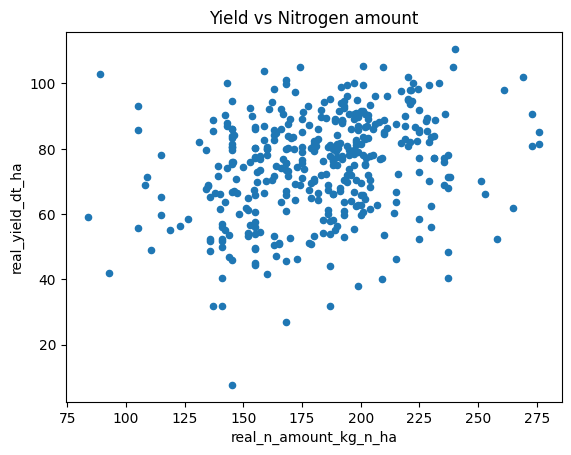

In [7]:
# Let's plot a graph with the yield and the nitrogen amount per hectare
df["real_yield_dt_ha"] = df["real_yield_dt_ha"].astype(float)
df["real_n_amount_kg_n_ha"] = df["real_n_amount_kg_n_ha"].astype(float)

# Use the farm as color
df.plot.scatter(y="real_yield_dt_ha", x="real_n_amount_kg_n_ha", title="Yield vs Nitrogen amount")

## Conclusions about the data

From the analysis of the dataset, we can draw the following conclusions:

1. **Data Points**: We have a total of 396 data points after filtering for winter wheat crops.
2. **Farm Distribution**: The dataset includes data from multiple farms, which have been anonymized for privacy.
3. **Yield vs Nitrogen Amount**: The scatter plot of yield versus nitrogen amount per hectare shows the relationship between these two variables. This can help in understanding how nitrogen application affects crop yield.
4. **Data Cleaning**: The dataset has been cleaned by removing unnecessary columns and handling missing values, ensuring the analysis is based on accurate and relevant data.

These insights can help in making informed decisions regarding crop management and optimizing nitrogen usage for better yields.

### Statistical and Machine Learning Algorithms

To predict the yield based on the nitrogen amount and other features, we can use the following machine learning algorithms:

1. **Linear Regression**: This algorithm can be used to model the relationship between the dependent variable (yield) and one or more independent variables (e.g., nitrogen amount, area, etc.). The performance can be evaluated using the **Mean Squared Error (MSE)** metric.

2. **Random Forest Regressor**: This ensemble learning method can be used for regression tasks. It builds multiple decision trees and merges them to get a more accurate and stable prediction. The performance can be evaluated using the **R-squared (R²)** metric.

3. **Support Vector Regressor (SVR)**: This algorithm uses support vector machines for regression tasks. It tries to fit the best line within a threshold value. The performance can be evaluated using the **Mean Absolute Error (MAE)** metric.